In [15]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!pwd

/rg/shimron_prj/tal.oved/codes/modl_singlechannel/demo_modl_singlechannel


In [3]:
!which python3

/bin/python3


In [23]:
da = h5py.File("test/training_set_16.h5", 'r')
kspace = np.array(da["kspace"])[21,...]
target = np.array(da["reconstruction"])[21,...]



In [24]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(640,24)),(640,372))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()   
target_torch = cplx.to_tensor(target).float()   
mask_slice = np.ones((640,372))
mask_func = MaskFunc([0.08],[4])
mk1 = mask_func((1,1,372,2))[0,0,:,0]
knee_masks = mask_slice*mk1
mask_torch = torch.tensor(knee_masks[...,None]).float() 
kspace_goal = kspace_torch  
kspace_torch = kspace_torch*mask_torch

"""
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs[0].imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
axs[0].set_title('Input')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.flipud(np.abs(mask_torch)), cmap='gray')
axs[1].set_title('Output')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.log(np.abs(cplx.to_numpy(T.fft2(target_torch)))), cmap='gray')
axs[2].set_title('Target')
fig.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(20,10))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
axs.set_title('Input')
fig.colorbar(im1, ax=axs)
plt.show()
"""


"\nfig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns\n# Plot each image in a subplot\nim1 = axs[0].imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')\naxs[0].set_title('Input')\nfig.colorbar(im1, ax=axs[0])\nim2 = axs[1].imshow(np.flipud(np.abs(mask_torch)), cmap='gray')\naxs[1].set_title('Output')\nfig.colorbar(im2, ax=axs[1])\nim3 = axs[2].imshow(np.log(np.abs(cplx.to_numpy(T.fft2(target_torch)))), cmap='gray')\naxs[2].set_title('Target')\nfig.colorbar(im3, ax=axs[2])\nplt.tight_layout()\nplt.show()\n\nfig, axs = plt.subplots(1, 1, figsize=(20,10))  # 1 row, 3 columns\n# Plot each image in a subplot\nim1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')\naxs.set_title('Input')\nfig.colorbar(im1, ax=axs)\nplt.show()\n"

In [18]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [19]:
checkpoint_file = "checkpoints/model_6.pt"
checkpoint = torch.load(checkpoint_file,map_location=device)

In [25]:
params = checkpoint["params"]
single_MoDL = UnrolledModel(params).to(device)
single_MoDL.load_state_dict(checkpoint['model'])

shared weights


<All keys matched successfully>

In [21]:
kspace_torch.shape

torch.Size([640, 372, 2])

In [26]:
with torch.no_grad():
    kspace_torch = kspace_torch.unsqueeze(0).to(device)
    mask_torch = mask_torch.unsqueeze(0).to(device)
    im_out = single_MoDL(kspace_torch.float(),mask=mask_torch)

torch.Size([1, 640, 372])
Tal
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372, 2])
Tal
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372, 2])
Tal
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372, 2])
Tal
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372])
torch.Size([1, 640, 372, 2])


torch.Size([1, 640, 372])


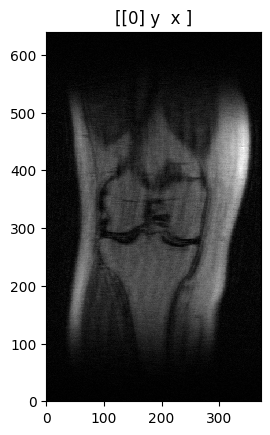

/tmp/ipykernel_306952/3410978523.py:2: RuntimeWarning: divide by zero encountered in log
  pl.ImagePlot(np.log(np.abs(cplx.to_numpy(kspace_torch.cpu()))).squeeze(0))
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:444: RuntimeWarning: invalid value encountered in scalar add
  vmid = np.float64(self.norm.vmin) + dv / 2


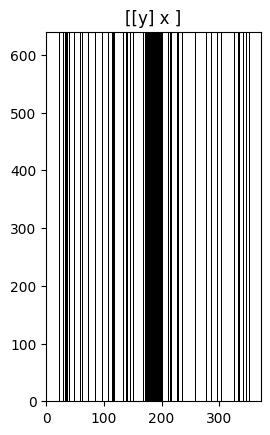

In [27]:

pl.ImagePlot(cplx.to_numpy(T.ifft2(kspace_torch.cpu())))
pl.ImagePlot(np.log(np.abs(cplx.to_numpy(kspace_torch.cpu()))).squeeze(0))

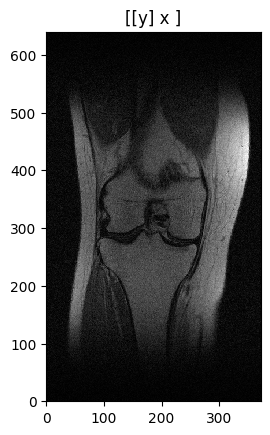

torch.Size([640, 372])


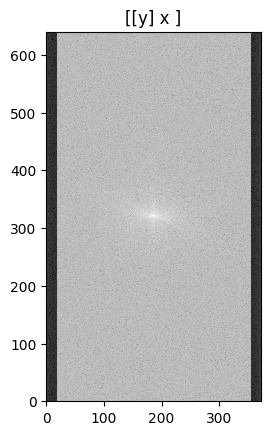

In [28]:
pl.ImagePlot(cplx.to_numpy(target_torch.cpu()))
pl.ImagePlot(np.log(np.abs(cplx.to_numpy(T.fft2(target_torch.cpu())))))

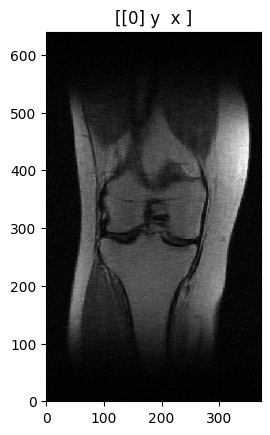

torch.Size([1, 640, 372])


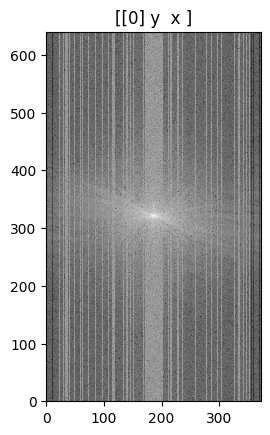

In [29]:
pl.ImagePlot(cplx.to_numpy(im_out.cpu()))
pl.ImagePlot(np.log(np.abs(cplx.to_numpy(T.fft2(im_out.cpu())))))

torch.Size([1, 640, 372])


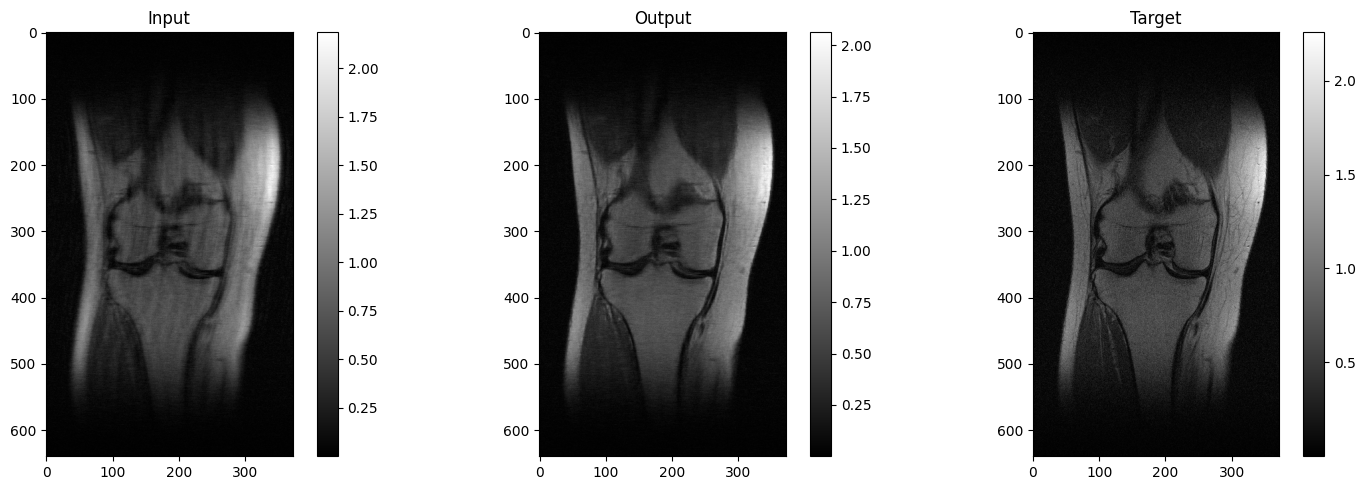

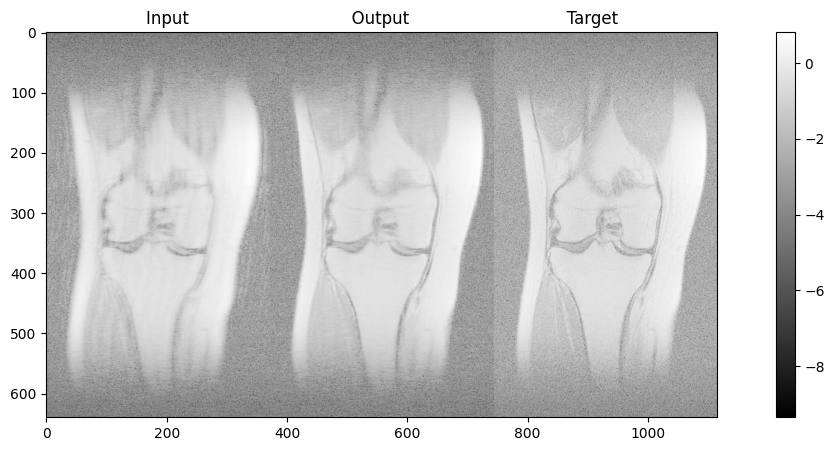

In [32]:
cplx_image_target = cplx.to_numpy(target_torch.cpu())
cplx_image_in = cplx.to_numpy(T.ifft2(kspace_torch.cpu())).squeeze(0)
cplx_image_out = cplx.to_numpy(im_out.cpu()).squeeze(0)
# Create a figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot each image in a subplot
im1 = axs[0].imshow(np.flipud(np.abs(cplx_image_in)), cmap='gray')
axs[0].set_title('Input')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.flipud(np.abs(cplx_image_out)), cmap='gray')
axs[1].set_title('Output')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.flipud(np.abs(cplx_image_target)), cmap='gray')
axs[2].set_title('Target')
fig.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.show()

plt_concat = np.concatenate((np.flipud(np.abs(cplx_image_in)),np.flipud(np.abs(cplx_image_out)),np.flipud(np.abs(cplx_image_target))),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns
im = axs.imshow(plt_concat, cmap='gray')
axs.set_title('Input                               Output                              Target')
fig.colorbar(im, ax=axs)
plt.show()


torch.Size([640, 372])
torch.Size([1, 640, 372])
(640, 372)
(640, 372)
(640, 372)


/tmp/ipykernel_306952/1631466599.py:11: RuntimeWarning: divide by zero encountered in log
  im1 = axs[0].imshow(np.log(np.abs(cplx_image_in)), cmap='gray')


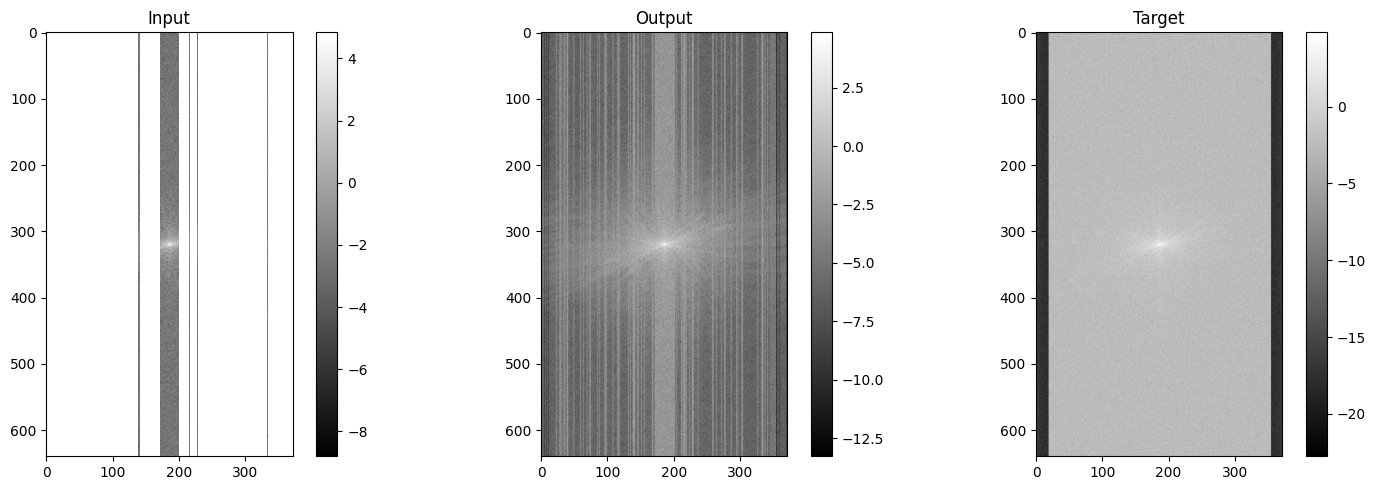

/tmp/ipykernel_306952/1631466599.py:26: RuntimeWarning: divide by zero encountered in log
  im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')


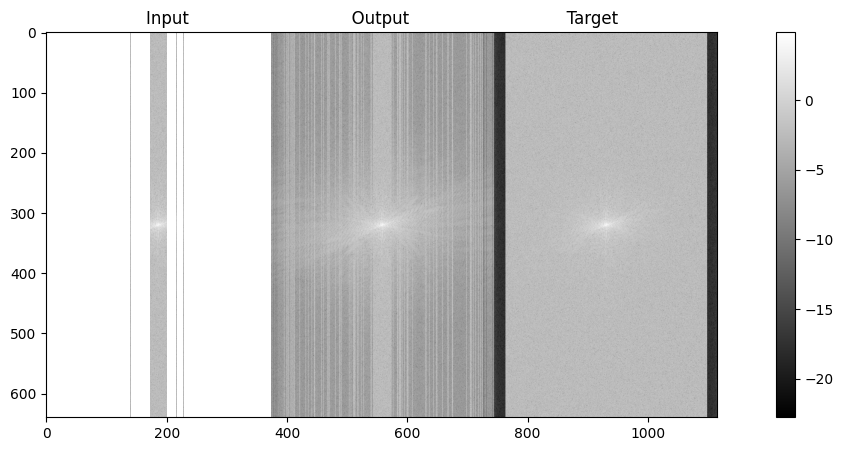

/tmp/ipykernel_306952/1631466599.py:31: RuntimeWarning: divide by zero encountered in log
  pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))


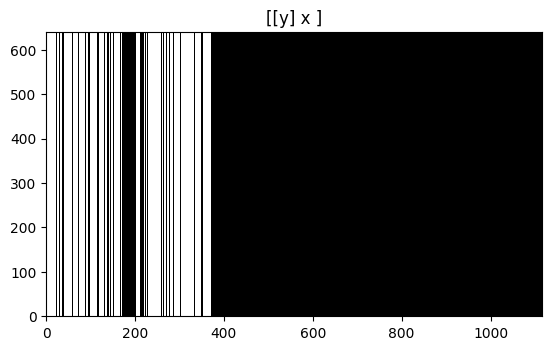

In [31]:
cplx_image_target = np.abs(cplx.to_numpy(T.fft2(target_torch.cpu())))
cplx_image_in = np.abs(cplx.to_numpy(kspace_torch.cpu()).squeeze(0))
cplx_image_out = np.abs(cplx.to_numpy(T.fft2(im_out.cpu())).squeeze(0))
print(cplx_image_target.shape)
print(cplx_image_in.shape)
print(cplx_image_out.shape)
# Create a figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot each image in a subplot
im1 = axs[0].imshow(np.log(np.abs(cplx_image_in)), cmap='gray')
axs[0].set_title('Input')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.log(np.abs(cplx_image_out)), cmap='gray')
axs[1].set_title('Output')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.log(np.abs(cplx_image_target)), cmap='gray')
axs[2].set_title('Target')
fig.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.show()


plt_concat = np.concatenate((cplx_image_in,cplx_image_out,cplx_image_target),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns
im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')
axs.set_title('Input                               Output                              Target')
fig.colorbar(im, ax=axs)
plt.show()

pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))